<a href="https://colab.research.google.com/github/Shavidika/next-word-prediction/blob/Bawantha/LSTM_Next_Word_Prediction_Group33_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'medium-articles-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F748442%2F1294572%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240621%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240621T152537Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7cb4cce7cd21f16593774711c57111d79556b81f4314e7551f09bdde2fb0e8fe36798a23182a8fbcc0d3dfd6233ec4a217f3368c8c4d21caccdeb75ec9444f490a1299e208723184d97aa012bb9e0aabb02d90f7aee1b136a6633d7eebd956c4562a56a26f3fe01e014326a4a7e7761db5ee36e471eb9c1c9b9858a1bcfabb1a07f88db2e061d3c9b059186374548121009b6eb270dc341eef668c991f1dc5a6445b44f631100a77631c502bfd2ae0c881cb9d28980cd8e4d0abec2602fc7496bee755a1c3701c28993fddcfc98cad734d3f07fce986addc97616eb39d077a69d5271bfdced8bd7caa3e5d24341f48e1bcd196fdc3e4d65ba5807ec52521c7cd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1425224888 bytes downloaded
Downloaded and uncompressed: medium-articles-dataset
Data source import complete.


### Table Content
------------------

- [Introduction](#intro)
- [Import libraries and packages](#ilp)
- [Dataset Information](#di)
- [Separate 'Title' field and preprocess it](#preprocess)
    - [Removing unwanted charaters and words](#remv)
    - [Tokenization and word_index (vocabulary) ](#token)
    - [Convert titles into sequences and Make n_gram model](#ngram)
    - [Make all titles with same length and padding them](#pad)
- [Preprare features (X) and labels (Y)](#xy)
- [Architechture of Bidirectional LSTM neural network](#blstm)
- [Train Bi-LSTM neural network](#train)
- [Plotting accuracy and loss graph](#acc)
- [Predict new title (Testing)](#new)

----------------




<a name="intro"></a>

# Introduction

**Next Word Prediction (also called Language Modeling) is the task of predicting what word comes next. It is one of the fundamental tasks of NLP.**

Image reference: https://medium.com/@antonio.lopardo/the-basics-of-language-modeling-1c8832f21079

![gg.png](attachment:426089b0-5844-4928-a797-40e0015c1a93.png)

#### Application Language Modelling

**1) Mobile keyboard text recommandation**

![fff.jpg](attachment:0cd813a1-ea03-40b9-86d7-0585d994a36e.jpg)

**2) Whenever we search for something on any search engine, we get many suggestions and,  as we type new words in it, we get better recommendations according to our searching context. So, how will it happen??? **

![Screenshot (21).png](attachment:72ee772e-4ef9-4e79-a364-5dcf8f558e4a.png)


It is poosible through natural language processing (NLP) technique. Here, we will use NLP and try to make a prediction model using Bidirectional LSTM (Long short-term memory) model that will predict next words of sentence.


<a name="ilp"></a>
# Import necessary libraries and packages

In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
# Dataset information

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing


In [ ]:
# URL of the raw CSV file from GitHub
url = 'https://raw.githubusercontent.com/Shavidika/next-word-prediction/Bawantha/backend/medium_data.csv'

# Load the CSV file from the URL
medium_data = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(medium_data.head())

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


Here, we have a **10 different fields and 6508 records** but we will only use **title field** for predicting next word.

In [ ]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


<a name="preprocess"></a>
# Display titles of various articles  and preprocess them

In [ ]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


<a name="ngram"></a>
#### Titles text into sequences and make n_gram model

suppose, we have sentence like **"I am Yash"** and this will convert into a sequence with their respective tokens **{'I': 1,'am': 2,'Yash': 3}**. Thus, output will be  **[ '1' ,'2' ,'3' ]**

Likewise, our all titles will be converted into sequences.

Then,
we will make a n_gram model for good prediction.

Below image explain about everything.

![Capture.PNG](attachment:48ad80b3-90bf-4cf6-99f8-7dcfd467d1f8.PNG)


In [ ]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


<a name="pad"></a>
#### Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [ ]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

<a name="xy"></a>
# Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


<a name="blstm"></a>
# Architechture of Bidirectional LSTM Neural Network

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

Image reference: https://www.researchgate.net/figure/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan_fig8_334268507
![lstm.png](attachment:c34341f6-d243-478a-b4bd-bf242759cd50.png)

**Bidirectional LSTM**
Image reference: https://paperswithcode.com/method/bilstm
![bi.png](attachment:d26c6b0c-cbdf-45a5-b88b-2b352d7b7d63.png)

<a name="train"></a>
# Bi- LSTM Neural Network Model training

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.0982 - loss: 7.0809
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1742 - loss: 5.7385
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.2063 - loss: 4.8835
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2671 - loss: 4.0675
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.3165 - loss: 3.5230
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.3647 - loss: 3.1335
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.3962 - loss: 2.9015
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4144 - loss: 2.7431
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.4385 - loss: 2.5819
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4501 - loss: 2.4962
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4573 - loss: 2.4486
Epoch 12

<a name="acc"></a>
# Plotting model accuracy and loss

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

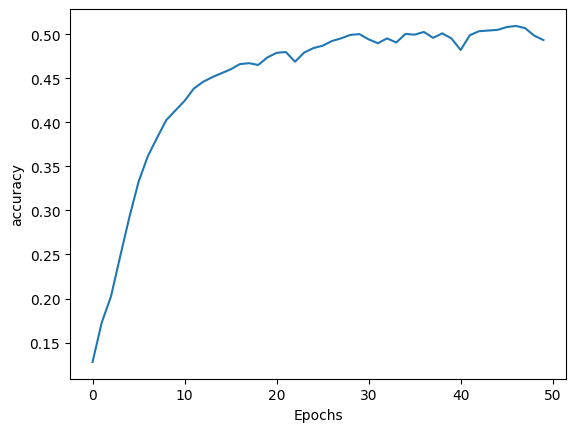

In [ ]:
plot_graphs(history, 'accuracy')

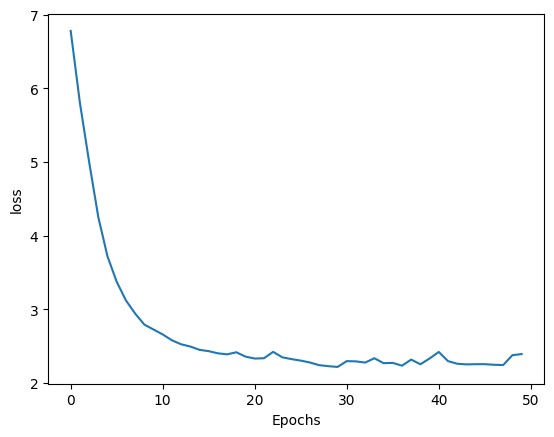

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
model.save("next_word_prediction_model_medium_2.h5")


In [ ]:
model.save("next_word_prediction_model_medium.keras")


In [ ]:
max_length = max([len(input_sequence) for input_sequence in input_sequences])
max_length

40

In [ ]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer_medium_2.json', 'w') as file:
    file.write(tokenizer_json)

# varify model


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
model = load_model("next_word_prediction_model.h5")

# Print the model architecture
model.summary()

# Define a function to predict the next word
def predict_next_word(model, tokenizer, seed_text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    return output_word

# Example of using the model to predict the next word
seed_text = "The economy is"
next_word = predict_next_word(model, tokenizer, seed_text, max_sequence_len)
print(f"Seed text: '{seed_text}' -> Next word: '{next_word}'")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'next_word_prediction_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<a name="new"></a>
# Predicting next word of title

In [ ]:
pip install --upgrade tensorflow keras